## CFS/GFS Basic Weather Maps

### Description:

In this python notebook, some basic weather plots are made from online data based on a user-specified date and lat-lon domain.  CFSR data is used for 1979-2011, CFS V2 analysis for 2011-near present, and GFS analysis for any time within 10 days of the present.


### Notes:

The date and region can be set below.  The date must be within the period of available data, which is from 1979 through near-real-time. Internet access is required. 

Many more variables are available from the accessed datasets and could be easily added to the code.

The following modules are used: numpy, netCDF4, matplotlib, cartopy, datetime, and scipy.

This code has been run in python 3.7 but not extensively tested.  If you find any errors or have any suggestions or improvements, please let me know at Mathew_Barlow@uml.edu. Thanks!

### History:

Initial release: 6 Mar 2020, Most recent update: 12 Mar 2020

### Acknowledgements:

Support from NSF AGS-1623912 and AGS-1657921 is gratefully acknowledged.


### Step 1.  Set date, time, and region

In [1]:
year = 1993
month = 3
day = 13
hour = 12  # can be 0, 6, 12, or 18

(lat1,lat2)=(20,60)
(lon1,lon2)=(-130,-60)

### Step 2.  Import needed modules

In [2]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import calendar
from scipy.ndimage import gaussian_filter

### Step 3. Define constants

In [3]:
# general constants
re=6.37e6
g=9.81
cp=1004.5
r=2*cp/7
kap=r/cp
omega=7.292e-5
pi=3.14159265

# values for dealing with lat-lon domain
lon1tick=lon1
lon2tick=lon2
shift = 0
if (lon2 <0)&(lon1 <0):
    lon1=lon1+360
    lon2=lon2+360
if (lon1 <0)&(lon2 >0):
    shift = 1  # if needed, shift data to -180 to 180 

# values related to the time and date
dt = datetime(year, month, day, hour)    
fdate = dt.strftime('%d %b %Y %H')
syear = dt.strftime('%Y')
smonth = dt.strftime('%m')
sday = dt.strftime('%d')
shour = dt.strftime('%H')
now = datetime.now()

### Step 4.  Acquire global data 
Access the remote dataset and retrieve variables.  Note that this may take some time, depending on your internet access and on the burden on the remote server.

Note: if the date and time specified above do not correspond to the available period of data, the rest of the code will fail.  It would be better to code a gentle failure and/or have the date default to the current time, but that has not been implemented yet.

In [4]:
# CFSR is available for Jan 1979 - Mar 2011
if dt < datetime(2011, 4, 1, 0):
    site = 'https://www.ncdc.noaa.gov'
    section = 'thredds/dodsC/cfs_reanl_6h_pgb'
    name = 'pgbhnl.gdas.'
    url = site + '/' + section + '/' + syear + '/' + syear + smonth 
    url = url + '/' + syear + smonth + sday + '/' + name + syear + smonth + sday + shour + '.grb2'
    file_in=netCDF4.Dataset(url) 
    # file_in.variables.keys()  # to list all available variables
    lat_in = file_in.variables['lat'][:]
    lon_in = file_in.variables['lon'][:]
    lev = file_in.variables['isobaric'][:]
    
    nlev = lev.size
    nx = lon_in.size
    ny = lat_in.size
    nz500 = np.argmin(np.abs(lev-50000))+5

    hgt500_in = file_in.variables['Geopotential_height_isobaric'][0,nz500,:,:]
    u500_in = file_in.variables['u-component_of_wind_isobaric'][0,nz500,:,:]
    v500_in = file_in.variables['v-component_of_wind_isobaric'][0,nz500,:,:]
    t500_in = file_in.variables['Temperature_isobaric'][0,nz500,:,:]
    vvel500_in = file_in.variables['Vertical_velocity_pressure_isobaric'][0,nz500,:,:]
    mslp_in = file_in.variables['Pressure_msl'][0,:,:]
    pwat_in = file_in.variables['Precipitable_water_entire_atmosphere_single_layer'][0,:,:]
    
    file_in.close()
    
    # reverse latitude (CFSR lat runs from 90 to -90)
    lat_in = np.flip(lat_in)
    hgt500_in = np.flip(hgt500_in, axis=0)
    u500_in = np.flip(u500_in, axis=0)
    v500_in = np.flip(v500_in, axis=0)
    t500_in = np.flip(t500_in, axis=0)
    vvel500_in = np.flip(vvel500_in, axis=0)
    mslp_in = np.flip(mslp_in, axis=0)
    pwat_in = np.flip(pwat_in, axis=0)
    
# CFS V2 analysis is available for Apr 2011 through near real-time   
if (dt >= datetime(2011, 4, 1, 0)) & (dt < now + timedelta(days=-10)):
    
    site = 'https://www.ncdc.noaa.gov'
    section = 'thredds/dodsC/cfs_v2_anl_6h_pgb'
    name = 'cdas1.t' + shour + 'z.pgrbhanl.grib2'
    url = site + '/' + section + '/' + syear + '/' + syear + smonth 
    url = url + '/' + syear + smonth + sday + '/' + name
    file_in=netCDF4.Dataset(url) 
    # file_in.variables.keys()  # to list all available variables
    lat_in = file_in.variables['lat'][:]
    lon_in = file_in.variables['lon'][:]
    lev = file_in.variables['isobaric'][:]
    
    nlev = lev.size
    nx = lon_in.size
    ny = lat_in.size
    nz500 = np.argmin(np.abs(lev-50000))+5

    hgt500_in = file_in.variables['Geopotential_height_isobaric'][0,nz500,:,:]
    u500_in = file_in.variables['u-component_of_wind_isobaric'][0,nz500,:,:]
    v500_in = file_in.variables['v-component_of_wind_isobaric'][0,nz500,:,:]
    t500_in = file_in.variables['Temperature_isobaric'][0,nz500,:,:]
    vvel500_in = file_in.variables['Vertical_velocity_pressure_isobaric'][0,nz500,:,:]
    mslp_in = file_in.variables['Pressure_msl'][0,:,:]
    pwat_in = file_in.variables['Precipitable_water_entire_atmosphere_single_layer'][0,:,:]
    
    file_in.close()
    
    # reverse latitude (CFSR lat runs from 90 to -90)
    lat_in = np.flip(lat_in)
    hgt500_in = np.flip(hgt500_in, axis=0)
    u500_in = np.flip(u500_in, axis=0)
    v500_in = np.flip(v500_in, axis=0)
    t500_in = np.flip(t500_in, axis=0)
    vvel500_in = np.flip(vvel500_in, axis=0)
    mslp_in = np.flip(mslp_in, axis=0)
    pwat_in = np.flip(pwat_in, axis=0)

# GFS analysis is available for most recent 10 days
if dt >= now + timedelta(days=-10):
 
    site = 'https://nomads.ncep.noaa.gov'
    section = 'dods/gfs_0p25/gfs' + syear + smonth + sday
    name = 'gfs_0p25_' + shour + 'z_anl'
    url = site + '/' + section + '/' + name
    file_in=netCDF4.Dataset(url) 
    # file_in.variables.keys()  # to list all available variables
    lat_in = file_in.variables['lat'][:]
    lon_in = file_in.variables['lon'][:]
    lev = file_in.variables['lev'][:]
    
    nlev = lev.size
    nx = lon_in.size
    ny = lat_in.size
    nz500 = np.argmin(np.abs(lev-500))

    hgt500_in = file_in.variables['hgtprs'][0,nz500,:,:]
    u500_in = file_in.variables['ugrdprs'][0,nz500,:,:]
    v500_in = file_in.variables['vgrdprs'][0,nz500,:,:]
    t500_in = file_in.variables['tmpprs'][0,nz500,:,:]
    vvel500_in = file_in.variables['vvelprs'][0,nz500,:,:]
    mslp_in = file_in.variables['prmslmsl'][0,:,:]
    pwat_in = file_in.variables['pwatclm'][0,:,:]
    
    file_in.close()
    


### Step 5.  Extract the domain of interest from the global data

In [5]:
# deal with domains that cross lon=0
if shift==1:
    ixs=np.argmin(np.abs(lon_in-180))
    lons=lon_in[ixs]
    t500_in=np.roll(t500_in,ixs,axis=2)
    u500_in=np.roll(u500_in,ixs,axis=2)
    v500_in=np.roll(v500_in,ixs,axis=2)
    hgt500_in=np.roll(hgt500_in,ixs,axis=2)
    vvel500_in=np.roll(vvel500_in,ixs,axis=2)
    lon_in=np.roll(lon_in,ixs,axis=0)
    lon_in[lon_in>=180]=lon_in[lon_in>=180]-360

# get array indices for lat-lon range
# specified above
iy1 = np.argmin( np.abs( lat_in - lat1 ) )
iy2 = np.argmin( np.abs( lat_in - lat2 ) ) 
ix1 = np.argmin( np.abs( lon_in - lon1 ) )
ix2 = np.argmin( np.abs( lon_in - lon2 ) )  

# select specified lat-lon range
t500=t500_in[iy1:iy2,ix1:ix2]
lon=lon_in[ix1:ix2]
lat=lat_in[iy1:iy2]
u500=u500_in[iy1:iy2,ix1:ix2]
v500=v500_in[iy1:iy2,ix1:ix2]
hgt500=hgt500_in[iy1:iy2,ix1:ix2]
vvel500=vvel500_in[iy1:iy2,ix1:ix2]
mslp=mslp_in[iy1:iy2,ix1:ix2]
pwat=pwat_in[iy1:iy2,ix1:ix2]

# make 2d arrays of lat and lon, for derivative calculations
xlon,ylat=np.meshgrid(lon,lat)

# define potential temperature and Coriolis parameter
theta500=t500*(1000/500)**kap
f=2*omega*np.sin(ylat*pi/180)

### Step 6.  Define functions to calculate horizontal derivatives

In [6]:
def ddx(f):
# use center-difference, assuming evenly spaced lon
# except for side-boundaries, where use forward diff
    x = (xlon*np.pi*re/180)*np.cos(ylat*np.pi/180)
    dx=np.roll(x,-1,axis=1)-np.roll(x,1,axis=1)
    ddx_f=(np.roll(f,-1,axis=1)-np.roll(f,1,axis=1))/dx
    ddx_f[:,0]=(f[:,1]-f[:,0])/(x[:,1]-x[:,0])
    ddx_f[:,-1]=(f[:,-2]-f[:,-1])/(x[:,-2]-x[:,-1])
    return(ddx_f)
    
def ddy(f):
# use center-difference, assuming evenly spaced lon
# except for N/S boundaries, where use forward diff
    y = ylat*np.pi*re/180
    dy=np.roll(y,-1,axis=0)-np.roll(y,1,axis=0)
    ddy_f=(np.roll(f,-1,axis=0)-np.roll(f,1,axis=0))/dy
    ddy_f[0,:]=(f[1,:]-f[0,:])/(y[1,:]-y[0,:])
    ddy_f[-1,:]=(f[-2,:]-f[-1,:])/(y[-2,:]-y[-1,:])
    return(ddy_f)

### Step 7.  Calculate vorticity and vorticity advection

In [7]:
# calculate relative vorticity, using spherical coordinates

ddx_v=ddx(v500)
ddy_ucos=ddy(u500*np.cos(ylat*pi/180))
vort500=ddx_v-(1/np.cos(ylat*pi/180))*ddy_ucos

vort500_advec = -u500*ddx(vort500) -v500*ddy(vort500)

# geostrophic vorticity and geostrophic vorticity advection
# for high resolution data, geostrophic fields need to be calculated from a 
hgt500_smooth = gaussian_filter(hgt500, sigma=3)
ug = -(g/f)*ddy(hgt500_smooth)
vg = (g/f)*ddx(hgt500_smooth)
ddx_vg = ddx(vg)
ddy_ucosg = ddy(ug*np.cos(ylat*pi/180))
vortg = ddx_vg-(1/np.cos(ylat*pi/180))*ddy_ucosg
#vortg = ddx(vg)-ddy(ug)  # cartesian form
vortg_advec = -ug*ddx(vortg+f) -vg*ddy(vortg+f)

# advection of vorticity by the thermal wind
t500_smooth = gaussian_filter(t500, sigma=3)
ut = (r/(f*5E5))*ddy(t500_smooth)
vt = -(r/(f*5E5))*ddx(t500_smooth)
twind_advec = -ut*ddx(vortg+f) -vt*ddy(vortg+f)

### Step 8.  Plot 500 hPa Heights and Relative Vorticity

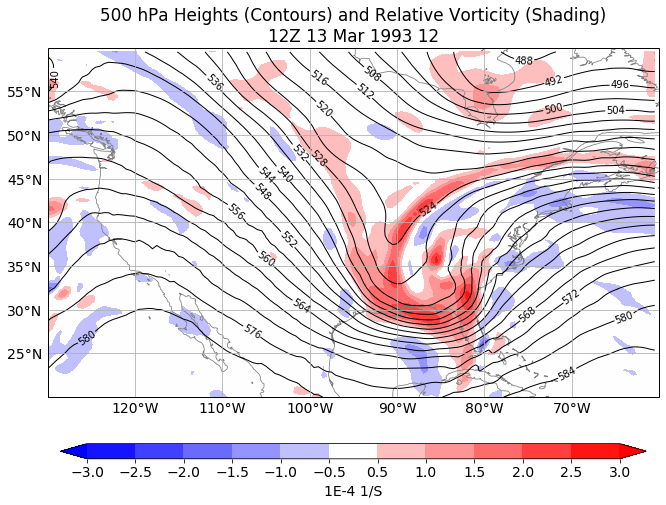

In [8]:

plt.rcParams.update({'font.size': 14})
llrat = (lon2-lon1)/(lat2-lat1)
plt.rcParams['figure.figsize'] = [15,15/llrat]

plt.figure(1)

states = NaturalEarthFeature(category='cultural', 
    scale='50m', facecolor='none', 
    name='admin_1_states_provinces_shp')

ax = plt.axes(projection=ccrs.PlateCarree( ))
ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
ax.coastlines('50m', linewidth=0.8,color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(lon1tick,lon2tick+10,10))
gl.ylocator = mticker.FixedLocator(np.arange(lat1,lat2+5,5))
plt.title('500 hPa Heights (Contours) and Relative Vorticity (Shading)\n'+shour+'Z '+fdate)

# heights as contours, in decameters
clevs=np.arange(400,600,4)
c=plt.contour(lon,lat,hgt500/10,clevs,transform=ccrs.PlateCarree(),colors='black',
    linewidths=1,extend='both')
plt.clabel(c,fontsize=10, fmt='%1.0f')

# vorticity as shading, in terms of 1E-4 1/S
clevs2=np.arange(-3,3+0.5,0.5)
clevs2=clevs2[clevs2!=0]  # remove zero contour interval
cp=plt.contourf(lon,lat,vort500/1E-4,clevs2,transform=ccrs.PlateCarree(),cmap='bwr',extend='both')
cbar = plt.colorbar(cp, ticks=clevs2, orientation='horizontal',shrink=0.7,aspect=35, pad=0.1)
cbar.set_label('1E-4 1/S')

plt.show()

### Step 9. Plot 500 hPa Heights and Vertical Velocity

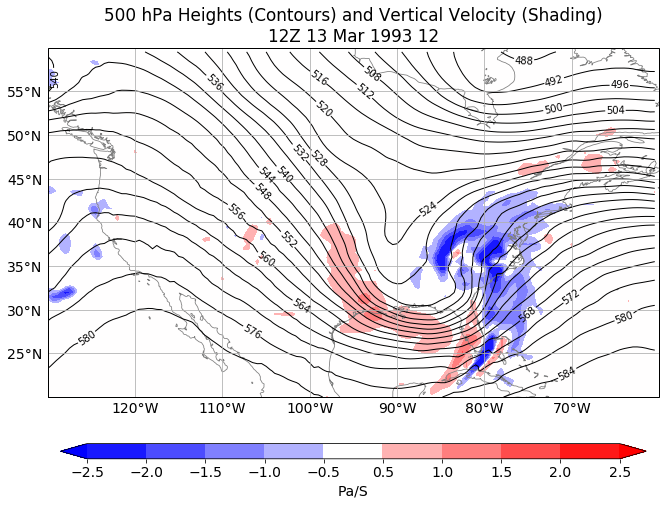

In [9]:
plt.rcParams.update({'font.size': 14})
llrat = (lon2-lon1)/(lat2-lat1)
plt.rcParams['figure.figsize'] = [15,15/llrat]

plt.figure(2)

states = NaturalEarthFeature(category='cultural', 
    scale='50m', facecolor='none', 
    name='admin_1_states_provinces_shp')

ax = plt.axes(projection=ccrs.PlateCarree( ))
ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
ax.coastlines('50m', linewidth=0.8,color='gray')
#ax.add_feature(states, linewidth=0.8, edgecolor='gray')  # to add states
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(lon1tick,lon2tick+10,10))
gl.ylocator = mticker.FixedLocator(np.arange(lat1,lat2+5,5))
plt.title('500 hPa Heights (Contours) and Vertical Velocity (Shading)\n'+shour+'Z '+fdate)

# heights as contours, in decameters
clevs=np.arange(400,600,4)
c=plt.contour(lon,lat,hgt500/10,clevs,transform=ccrs.PlateCarree(),colors='black',
    linewidths=1,extend='both')
plt.clabel(c,fontsize=10, fmt='%1.0f')

# vertical velocity as shading
clevs2=np.arange(-2.5,2.5+0.5,0.5)
clevs2=clevs2[clevs2!=0]  # remove zero contour interval
cp=plt.contourf(lon,lat,vvel500,clevs2,transform=ccrs.PlateCarree(),cmap='bwr',extend='both')
cbar = plt.colorbar(cp, ticks=clevs2, orientation='horizontal',shrink=0.7,aspect=35, pad=0.1)
cbar.set_label('Pa/S')

plt.show()


### Step 10. Plot SLP and Precipitable Water

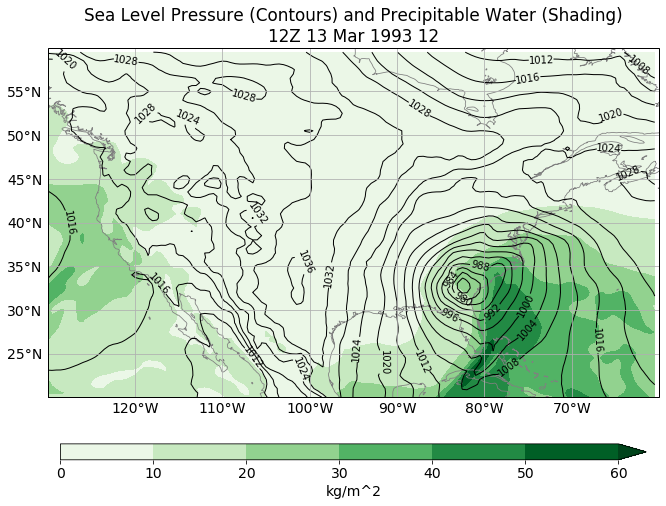

In [10]:
plt.rcParams.update({'font.size': 14})
llrat = (lon2-lon1)/(lat2-lat1)
plt.rcParams['figure.figsize'] = [15,15/llrat]

plt.figure(3)

states = NaturalEarthFeature(category='cultural', 
    scale='50m', facecolor='none', 
    name='admin_1_states_provinces_shp')

ax = plt.axes(projection=ccrs.PlateCarree( ))
ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
ax.coastlines('50m', linewidth=0.8,color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(lon1tick,lon2tick+10,10))
gl.ylocator = mticker.FixedLocator(np.arange(lat1,lat2+5,5))
plt.title('Sea Level Pressure (Contours) and Precipitable Water (Shading)\n'+shour+'Z '+fdate)

# heights as contours, in decameters
clevs=np.arange(960,1040,4)
c=plt.contour(lon,lat,mslp/100,clevs,transform=ccrs.PlateCarree(),colors='black',
    linewidths=1,extend='both')
plt.clabel(c,fontsize=10, fmt='%1.0f')

# vertical velocity as shading
clevs2=np.arange(0,70,10)
cp=plt.contourf(lon,lat,pwat,clevs2,transform=ccrs.PlateCarree(),cmap='Greens',
                extend='max')
cbar = plt.colorbar(cp, ticks=clevs2, orientation='horizontal',shrink=0.7,aspect=35, pad=0.1)
cbar.set_label('kg/m^2')

plt.show()